In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [2]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx
    
    
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力                                                                                                                                                                             
        self.t = None  # 教師ラベル                                                                                                                                                                                

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換                                                                                                                                              
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

    
def accuracy(y, t):
    t, y = t.argmax(axis=1), y.argmax(axis=1)
    a = (t==y).sum() / len(t)
    return a

epoch=10000 loss=0.16300506474891552
epoch=10000 accu=0.95


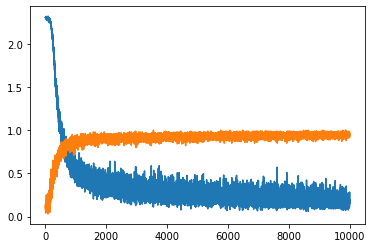

CPU times: user 1min 12s, sys: 32.3 s, total: 1min 45s
Wall time: 30 s


In [3]:
%%time
from common.functions import softmax, sigmoid, cross_entropy_error

class NN():
    def __init__(self, input_size, hidden_size, output_size):
        W1 = 0.01 * np.random.randn(input_size, hidden_size)
        b1 = np.zeros(hidden_size)
        W2 = 0.01 * np.random.randn(hidden_size, output_size)
        b2 = np.zeros(output_size)
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)           
        ]
        self.last_layer = SoftmaxWithLoss()

    def forward(self, x, t):
        for layer in self.layers:
            x = layer.forward(x)
        l = self.last_layer.forward(x, t)
        a = accuracy(x, t)
        return l, a
    
    def backward(self):
        gy = self.last_layer.backward()
        for layer in reversed(self.layers):
            gy = layer.backward(gy)
    
    def update(self, lr):
        for layer in self.layers:
            for p, g in zip(layer.params, layer.grads):
                p -= lr * g
    
    
nn = NN(len(x_train[0]), hidden_size=50, output_size=len(t_train[0]))

iters_num = 10000  # 繰り返しの回数を適宜設定すaる
train_size = x_train.shape[0]
batch_size = 100
lr = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

# Train NN
loss_list, accu_list = [], []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    xx = x_train[batch_mask]
    tt = t_train[batch_mask]
    
    l, a = nn.forward(xx, tt)
    loss_list.append(l)
    accu_list.append(a)

    nn.backward()
    nn.update(lr)
    
#Plot accuracy over time    
print(f"epoch={len(loss_list)} loss={loss_list[-1]}")
print(f"epoch={len(loss_list)} accu={accu_list[-1]}")
plt.plot(range(len(loss_list)), loss_list)
plt.plot(range(len(accu_list)), accu_list)
plt.show()